In [1]:
import matplotlib.pyplot as plt
from tqdm import trange
from algs import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from models.dbsl import DBSL
from env_cifar import *

In [2]:
images, labels = load_cifar10("datasets/CIFAR10")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)
print(features.shape)
print([len(clusters[k]) for k in range(10)])

(50000, 3072)
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


In [4]:
def run_experiment_cbscfd(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)

    env = CIFAR10BanditEnv(clusters, target_class=0)
    bandit = CBSCFD(num_arms=10, lambd=lambd, beta=beta, m=m, d=3072)

    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)

    return env.cumulative_mistakes

In [5]:
T = 4000
n_runs = 5
m = 20
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes = run_experiment_cbscfd(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


100%|██████████| 4000/4000 [00:02<00:00, 1772.66it/s]



Run 2/5


100%|██████████| 4000/4000 [00:02<00:00, 1833.71it/s]



Run 3/5


100%|██████████| 4000/4000 [00:02<00:00, 1814.64it/s]



Run 4/5


100%|██████████| 4000/4000 [00:02<00:00, 1850.17it/s]



Run 5/5


100%|██████████| 4000/4000 [00:02<00:00, 1867.62it/s]

num mistakes 41.8


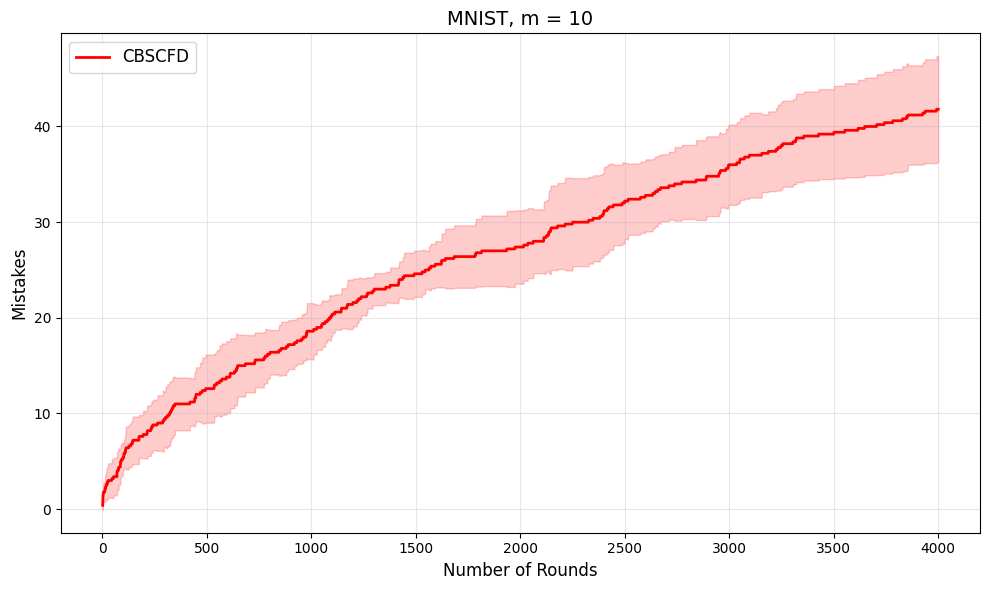

In [6]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='CBSCFD', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
def run_experiment_psi(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)

    env = CIFAR10BanditEnv(clusters, target_class=0)
    bandit = LinUCBwithPSI_rank1(n_arms=10,d=3072, epsilon=lambd, alpha=beta, rank=m)
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)

    return env.cumulative_mistakes

In [16]:
T = 4000
n_runs = 5
m = 20
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes = run_experiment_psi(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


100%|██████████| 4000/4000 [00:11<00:00, 350.98it/s]



Run 2/5


100%|██████████| 4000/4000 [00:11<00:00, 354.13it/s]



Run 3/5


100%|██████████| 4000/4000 [00:11<00:00, 360.54it/s]



Run 4/5


100%|██████████| 4000/4000 [00:11<00:00, 358.23it/s]



Run 5/5


100%|██████████| 4000/4000 [00:11<00:00, 353.17it/s]

num mistakes 40.6


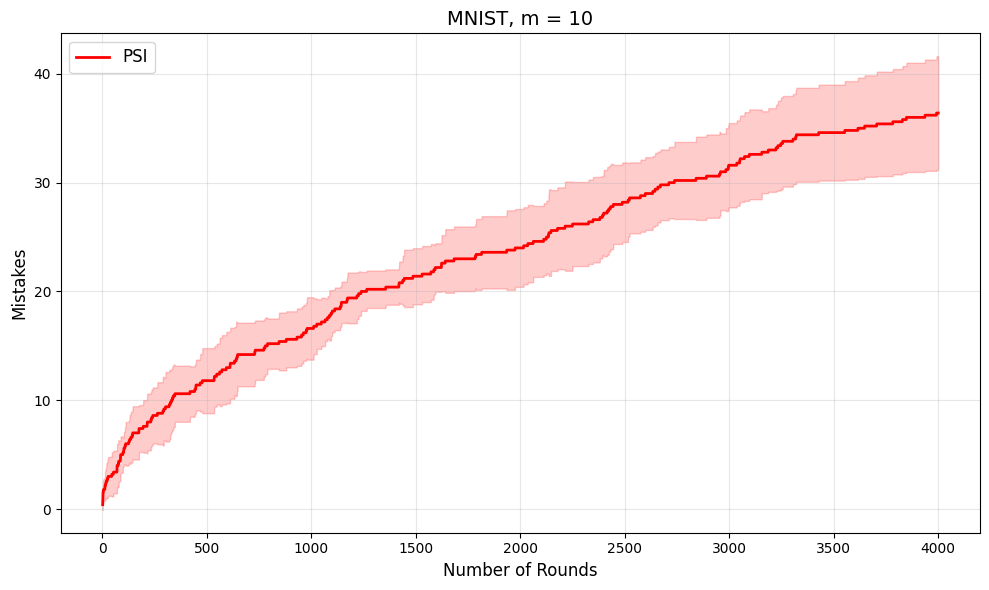

In [9]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='PSI', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

100%|██████████| 4000/4000 [03:59<00:00, 16.74it/s]


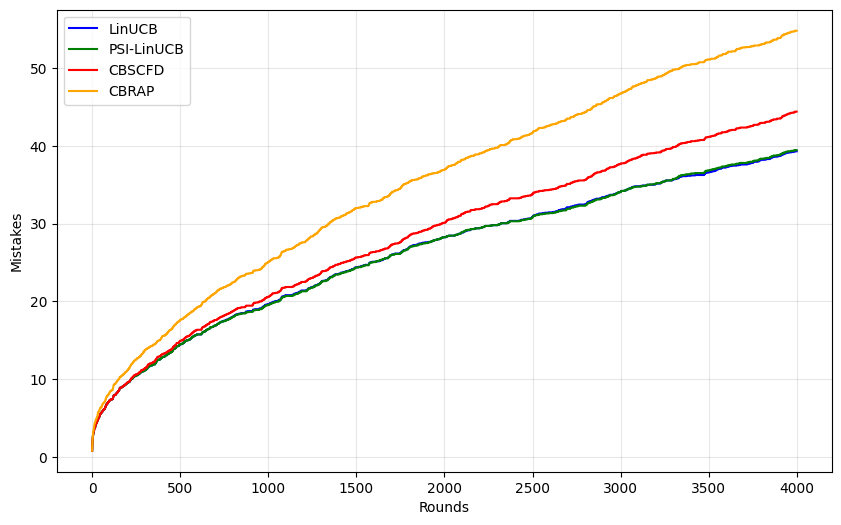


Final Results:
LinUCB: 39.3 ± 3.8
PSI-LinUCB: 39.5 ± 3.8
CBSCFD: 44.4 ± 3.7
CBRAP: 54.8 ± 6.1


In [9]:
T = 4000
n_runs = 20
d = 3072
num_arms = 10
lambd = epsilon = 1
beta = alpha = 1

m = 20

m_cbrap = 20

rank = 64

sketch = 50
eps = 8 #из статьи, найти cifar, они забили вроде на него


results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP',
                                 #'DBSL'
                                 ]}

for run in range(n_runs):
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, alpha, epsilon)
    psi = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
    cbscfd = CBSCFD(num_arms, lambd, beta, m, d)
    cbrap = CBRAP(num_arms, d, lambd, beta, m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)

    env_linucb = CIFAR10BanditEnv(clusters, target_class=0)
    env_psi = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbscfd = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbrap = CIFAR10BanditEnv(clusters, target_class=0)
    env_dbsl = CIFAR10BanditEnv(clusters, target_class=0)

    for t in trange(T):
        contexts = env_linucb.get_contexts()

        #LinUCB
        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        #linucb.append_interaction(contexts[action], action, reward)
        #linucb.batch_update([action])
        linucb.update(contexts[action], action, reward)

        #PSI-LinUCB
        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        #CBSCFD
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        #CBRAP
        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

        #DBSL
        # def observe(ind, x):
        #     return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)

plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange',
          # 'DBSL': 'purple'
          }
for name in results:
    mean = np.mean(results[name], axis=0)
    plt.plot(mean, label=name, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

Running cross-validation...
LinUCB best: {'alpha': 1, 'epsilon': 1}, mistakes: 5
PSI-LinUCB best: {'alpha': 1, 'epsilon': 1}, mistakes: 5
CBSCFD best: {'beta': 1, 'lambd': 1}, mistakes: 5
CBRAP best: {'beta': 1, 'lambd': 1}, mistakes: 12
Run 1/1


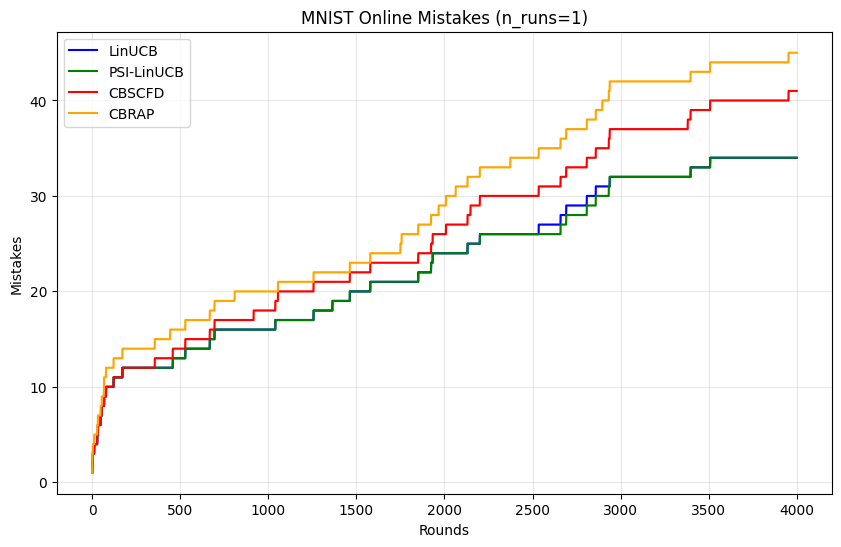


Final Results:
LinUCB: 34.0 ± 0.0
PSI-LinUCB: 34.0 ± 0.0
CBSCFD: 41.0 ± 0.0
CBRAP: 45.0 ± 0.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

betas = [-1, -2, 1, 2]
#lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]
lambdas = [1]

T_cv = 100
T = 4000
n_runs = 1
d = 3072
num_arms = 10
m = 20
m_cbrap = 20
sketch = 50
rank = 32
eps = 8


def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(num_arms, d, alpha, epsilon)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBSCFD(num_arms, lambd, beta, m, d)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params

def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd in product(betas, lambdas):
        np.random.seed(0)
        bandit = CBRAP(num_arms, d, lambd, beta, m_cbrap)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a], a) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], action, reward)
        if env.mistakes <= best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params

# def cv_dbsl():
#     best_score, best_params = float('inf'), {}
#     for beta, lambd in product(betas, lambdas):
#         np.random.seed(0)
#         bandit = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)
#         env = CIFAR10BanditEnv(clusters, target_class=0)
#         for t in range(T_cv):
#             ctx = env.get_contexts()
#             def observe(ind, x): return env.step(ind)
#             bandit.fit(ctx, observe)
#         if env.mistakes <= best_score:
#             best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd}
#     print(f"DBSL best: {best_params}, mistakes: {best_score}")
#     return best_params


print("Running cross-validation...")
params_linucb = cv_linucb()
params_psi = cv_psi()
params_cbscfd = cv_cbscfd()
params_cbrap = cv_cbrap()
# params_dbsl = cv_dbsl()


results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP',
                                 # 'DBSL'
                                 ]}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, params_linucb['alpha'], params_linucb['epsilon'])
    psi = LinUCBwithPSI_rank1(num_arms, d, params_psi['epsilon'], params_psi['alpha'], rank)
    cbscfd = CBSCFD(num_arms, params_cbscfd['lambd'], params_cbscfd['beta'], m, d)
    cbrap = CBRAP(num_arms, d, params_cbrap['lambd'], params_cbrap['beta'], m_cbrap)
    # dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=params_dbsl['beta'], lmd=params_dbsl['lambd'], robust=True)

    env_linucb = CIFAR10BanditEnv(clusters, target_class=0)
    env_psi = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbscfd = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbrap = CIFAR10BanditEnv(clusters, target_class=0)
    # env_dbsl = CIFAR10BanditEnv(clusters, target_class=0)

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], action, reward)

        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

        # def observe(ind, x): return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)


plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange',
# 'DBSL': 'purple'
}
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    plt.plot(mean, label=name, color=colors[name])
    plt.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'MNIST Online Mistakes (n_runs={n_runs})')
plt.show()


print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

In [2]:
from tqdm import trange
from algs_one_mtx import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP


from env_cifar import *

In [3]:
images, labels = load_cifar10("datasets/CIFAR10")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)
print(features.shape)
print([len(clusters[k]) for k in range(10)])

(50000, 3072)
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


Run 1/1


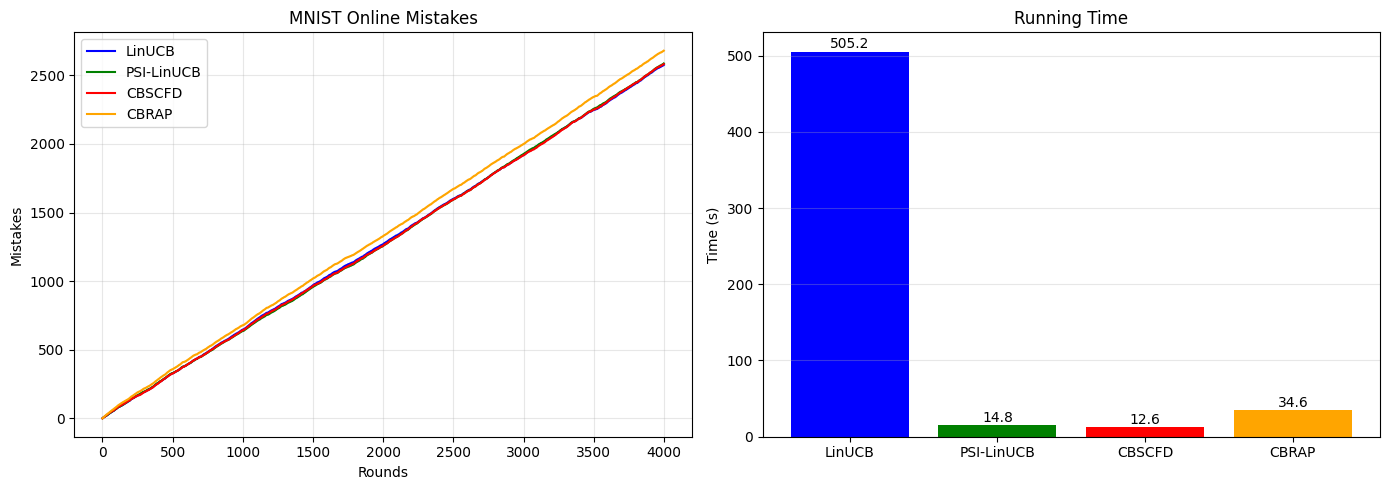


Final Results:
LinUCB: Mistakes=2575.0, Time=505.2s
PSI-LinUCB: Mistakes=2586.0, Time=14.8s
CBSCFD: Mistakes=2581.0, Time=12.6s
CBRAP: Mistakes=2679.0, Time=34.6s


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time

T = 4000
n_runs = 1
d = 3072
num_arms = 10

# LinUCB
alpha_lin = 0.01
epsilon_lin = 1

# PSI-LinUCB
alpha_psi = 0.0001
epsilon_psi = 1
rank_psi = 10

# CBSCFD
beta_cbscfd =  0.1
lambd_cbscfd = 0.0002
m_cbscfd = 30 #2144.

# CBRAP
beta_cbrap = 0.0001
lambd_cbrap = 2
m_cbrap = 20



results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', #'DBSL'
                                 ]}
times = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', #'DBSL'
                               ]}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, alpha_lin, epsilon_lin)
    psi = LinUCBwithPSI_rank1(d, epsilon_psi, alpha_psi, rank_psi)
    cbscfd = CBSCFD(lambd_cbscfd, beta_cbscfd, m_cbscfd, d)
    cbrap = CBRAP(d, lambd_cbrap, beta_cbrap, m_cbrap)


    env_linucb = CIFAR10BanditEnv(clusters, target_class=5)
    env_psi = CIFAR10BanditEnv(clusters, target_class=5)
    env_cbscfd = CIFAR10BanditEnv(clusters, target_class=5)
    env_cbrap = CIFAR10BanditEnv(clusters, target_class=5)
    env_dbsl = CIFAR10BanditEnv(clusters, target_class=5)

    time_linucb, time_psi, time_cbscfd, time_cbrap, time_dbsl = 0, 0, 0, 0, 0

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        # LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)
        time_linucb += time.perf_counter() - t0

        # PSI-LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)
        time_psi += time.perf_counter() - t0

        # CBSCFD
        t0 = time.perf_counter()
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)
        time_cbscfd += time.perf_counter() - t0

        # CBRAP
        t0 = time.perf_counter()
        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)
        time_cbrap += time.perf_counter() - t0



    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)


    times['LinUCB'].append(time_linucb)
    times['PSI-LinUCB'].append(time_psi)
    times['CBSCFD'].append(time_cbscfd)
    times['CBRAP'].append(time_cbrap)

# Графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График ошибок
ax = axes[0]
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange',
         # 'DBSL': 'purple'
          }
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    ax.plot(mean, label=name, color=colors[name])
ax.set_xlabel('Rounds')
ax.set_ylabel('Mistakes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('MNIST Online Mistakes')

# График времени (столбчатый)
ax = axes[1]
names = list(times.keys())
mean_times = [np.mean(times[name]) for name in names]
bars = ax.bar(names, mean_times, color=[colors[name] for name in names])
ax.set_ylabel('Time (s)')
ax.set_title('Running Time')
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, mean_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Результаты
print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: Mistakes={np.mean(arr[:,-1]):.1f}, Time={np.mean(times[name]):.1f}s")

In [12]:
#cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from itertools import product

betas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 2]
lambdas = [2e-4, 2e-3, 2e-2, 2e-1, 2, 20, 200, 2000, 20000]
# ranks = [10,20,30, 50,70, 90, 110,130, 150, 200]
# ms = [10,20,30, 50,70, 90, 110,130, 150, 200]
ranks = [10,14, 500]
ms = [10,14, 500]
# sketches = [10,20,30, 50,70, 90, 110,130, 150, 200]
# epss = [0.1, 1, 5, 8, 10]

T_cv = 4000
T = 4000
n_runs = 1
d = 3072
num_arms = 10


def cv_linucb():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon in product(betas, lambdas):
        np.random.seed(0)
        bandit = LinUCB_SM(d, alpha, epsilon)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon}
    print(f"LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_psi():
    best_score, best_params = float('inf'), {}
    for alpha, epsilon, rank in product(betas, lambdas, ranks):
        np.random.seed(0)
        bandit = LinUCBwithPSI_rank1(d, epsilon, alpha, rank)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'alpha': alpha, 'epsilon': epsilon, 'rank': rank}
    print(f"PSI-LinUCB best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbscfd():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBSCFD(lambd, beta, m, d)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = bandit.select_arm(ctx)
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBSCFD best: {best_params}, mistakes: {best_score}")
    return best_params


def cv_cbrap():
    best_score, best_params = float('inf'), {}
    for beta, lambd, m in product(betas, lambdas, ms):
        np.random.seed(0)
        bandit = CBRAP(d, lambd, beta, m)
        env = CIFAR10BanditEnv(clusters, target_class=0)
        for t in range(T_cv):
            ctx = env.get_contexts()
            action = int(np.argmax([bandit.score(ctx[a]) for a in range(num_arms)]))
            reward = env.step(action)
            bandit.update(ctx[action], reward)
        if env.mistakes < best_score:
            best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'm': m}
    print(f"CBRAP best: {best_params}, mistakes: {best_score}")
    return best_params


# def cv_dbsl():
#     best_score, best_params = float('inf'), {}
#     for beta, lambd, sketch, eps in product(betas, lambdas, sketches, epss):
#         np.random.seed(0)
#         bandit = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)
#         env = CIFAR10BanditEnv(clusters, target_class=0)
#         for t in range(T_cv):
#             ctx = env.get_contexts()
#             def observe(ind, x): return env.step(ind)
#             bandit.fit(ctx, observe)
#         if env.mistakes < best_score:
#             best_score, best_params = env.mistakes, {'beta': beta, 'lambd': lambd, 'sketch': sketch, 'eps': eps}
#     print(f"DBSL best: {best_params}, mistakes: {best_score}")
#     return best_params


print("Running cross-validation...")
# params_linucb = cv_linucb()
params_linucb = {'alpha': 0.01, 'epsilon': 0.2}
params_psi = cv_psi()
params_cbscfd = cv_cbscfd()
params_cbrap = cv_cbrap()
# params_dbsl = cv_dbsl()

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD',# 'CBRAP'
                                 ]}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, params_linucb['alpha'], params_linucb['epsilon'])
    psi = LinUCBwithPSI_rank1(d, params_psi['epsilon'], params_psi['alpha'], params_psi['rank'])
    cbscfd = CBSCFD(params_cbscfd['lambd'], params_cbscfd['beta'], params_cbscfd['m'], d)
    cbrap = CBRAP(d, params_cbrap['lambd'], params_cbrap['beta'], params_cbrap['m'])
    # dbsl = DBSL(d, sketch_size=params_dbsl['sketch'], eps=params_dbsl['eps'],
    #             beta=params_dbsl['beta'], lmd=params_dbsl['lambd'], robust=True)

    env_linucb = CIFAR10BanditEnv(clusters, target_class=0)
    env_psi = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbscfd = CIFAR10BanditEnv(clusters, target_class=0)
    env_cbrap = CIFAR10BanditEnv(clusters, target_class=0)
    # env_dbsl = CIFAR10BanditEnv(clusters, target_class=0)

    for t in trange(T, leave=False):
        contexts = env_linucb.get_contexts()

        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)

        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)

        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)

        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)

        # def observe(ind, x): return env_dbsl.step(ind)
        # dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    # results['DBSL'].append(env_dbsl.cumulative_mistakes)

plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', #'CBRAP': 'orange'
          }
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    plt.plot(mean, label=name, color=colors[name])
    plt.fill_between(range(T), mean - std, mean + std, alpha=0.2, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'CIFAR-10 Online Mistakes (n_runs={n_runs})')
plt.show()

print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: {np.mean(arr[:,-1]):.1f} ± {np.std(arr[:,-1]):.1f}")

print("\nBest params:")
print(f"LinUCB: {params_linucb}")
print(f"PSI-LinUCB: {params_psi}")
print(f"CBSCFD: {params_cbscfd}")
print(f"CBRAP: {params_cbrap}")
# print(f"DBSL: {params_dbsl}")

Running cross-validation...


KeyboardInterrupt: 

In [ ]:
LinUCB: {'alpha': 0.01, 'epsilon': 0.2}
PSI-LinUCB: {'alpha': 0.001, 'epsilon': 0.2, 'rank': 200}
CBSCFD: {'beta': 0.01, 'lambd': 0.2, 'm': 130}
CBRAP: {'beta': 0.0001, 'lambd': 2, 'm': 130}

ранги 20
LinUCB best: {'alpha': 0.01, 'epsilon': 0.2}
PSI-LinUCB best: {'alpha': 0.001, 'epsilon': 2}
CBSCFD best: {'beta': 0.01, 'lambd': 0.2}
CBRAP best: {'beta': 0.001, 'lambd': 2}

LinUCB: {'alpha': 0.01, 'epsilon': 0.2}
PSI-LinUCB: {'alpha': 0.1, 'epsilon': 2, 'rank': 10}
CBSCFD: {'beta': 0.0001, 'lambd': 2, 'm': 14}